In [1]:
import astropy.units as u
import glob
import numpy as np
import timing_analysis.plot_utils as plt_util
import timing_analysis.utils as tu
from astropy import log
from matplotlib import pyplot as plt
import os

%matplotlib inline

# Grab plotting info
markers, colorscheme = plt_util.plot_settings()

# Subtract red noise offset? (solution until PINT fix is in)
rn_subtract = True

# This option is probably temporary, but it runs everything without redoing the fit (as required for RN)
testing = False

# Print a legend for all backend/receiver combos? (be_format can be 'horiz' or 'vert')
be_legend = True
be_format = 'horiz'

# Currently designed to work in a dir with matching nb/wb yamls; will barf if not
configs = glob.glob('configs/J1643*.??.yaml')

#configs = glob.glob('testing_configs/*')

psr_names = []
for c in configs:
    stem = c.split('.')[0]
    if f'{stem}.nb.yaml' not in configs or f'{stem}.wb.yaml' not in configs:
        log.error(f'{stem} is missing either the nb or wb config file. You must have both.')
    else:
        psr_names.append(stem)
psr_names = np.unique(psr_names)

INFO: Working on J1643-1224 [unknown]
INFO: Par file created: 2022-03-05T02:00:26.071758 [timing_analysis.timingconfiguration]


INFO     (pint.toa                      ): Reading TOAs from the picklefile for `['/nanograv/share/15yr/timing/intermediate/20220209.Outlier.nb.3460db7/J1643-1224.nb/J1643-1224.nb_excise.tim']`


INFO: Selecting 22146 TOAs out of 24469 (2323 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 22144 TOAs out of 24469 (2 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 22144 TOAs out of 24469 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Exactly one frontend not JUMPed. [timing_analysis.lite_utils]


INFO     (pint.solar_system_ephemerides ): Set solar system ephemeris to de440 through astropy
INFO     (pint.toa                      ): Reading TOAs from the picklefile for `['/nanograv/share/15yr/timing/intermediate/20220913.Outlier.wb.281b67cb/J1643-1224.wb/J1643-1224.wb_excise.tim']`


INFO: Par file created: 2022-08-25T15:42:06.577063 [timing_analysis.timingconfiguration]
INFO: Selecting 503 TOAs out of 588 (85 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 503 TOAs out of 588 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-file'} [timing_analysis.timingconfiguration]
INFO: Selecting 478 TOAs out of 588 (25 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: All frontends are DMJUMPed. [timing_analysis.lite_utils]


WARNING  (pint.fitter                   ): Unexpected parameter toa_noise_params
WARNING  (pint.fitter                   ): Unexpected parameter toa_noise_params


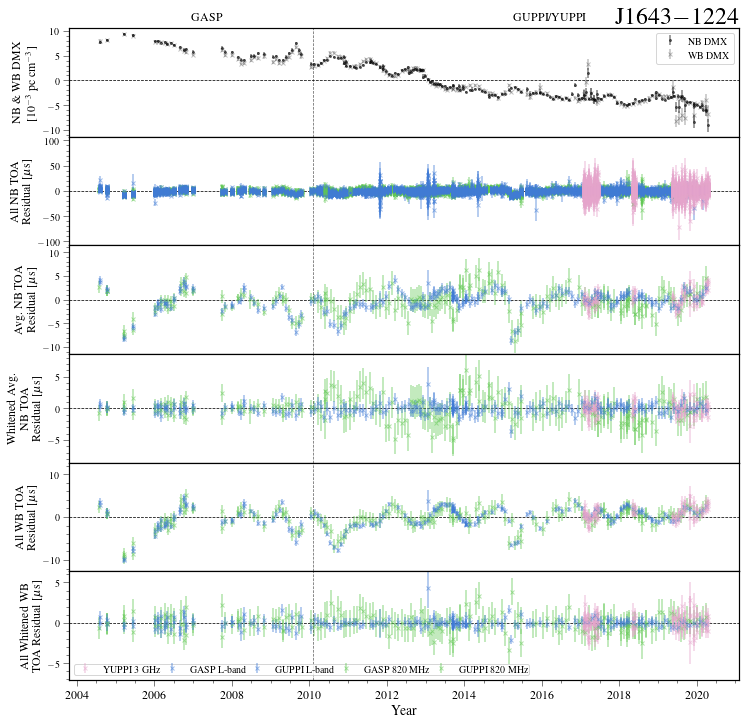

INFO: Working on J1643-1224gbt [unknown]
INFO: Par file created: 2022-03-05T00:29:22.209488 [timing_analysis.timingconfiguration]


INFO     (pint.toa                      ): Reading TOAs from the picklefile for `['/nanograv/share/15yr/timing/intermediate/20220209.Outlier.nb.3460db7/J1643-1224gbt.nb/J1643-1224gbt.nb_excise.tim']`


INFO: Selecting 17934 TOAs out of 19159 (1225 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 17932 TOAs out of 19159 (2 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 17932 TOAs out of 19159 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Exactly one frontend not JUMPed. [timing_analysis.lite_utils]


INFO     (pint.toa                      ): Reading TOAs from the picklefile for `['/nanograv/share/15yr/timing/intermediate/20220913.Outlier.wb.281b67cb/J1643-1224gbt.wb/J1643-1224gbt.wb_excise.tim']`


INFO: Par file created: 2022-10-13T19:52:13.973500 [timing_analysis.timingconfiguration]
INFO: Selecting 408 TOAs out of 491 (83 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 408 TOAs out of 491 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 408 TOAs out of 491 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: All frontends are DMJUMPed. [timing_analysis.lite_utils]


WARNING  (pint.fitter                   ): Unexpected parameter toa_noise_params
WARNING  (pint.fitter                   ): Unexpected parameter toa_noise_params


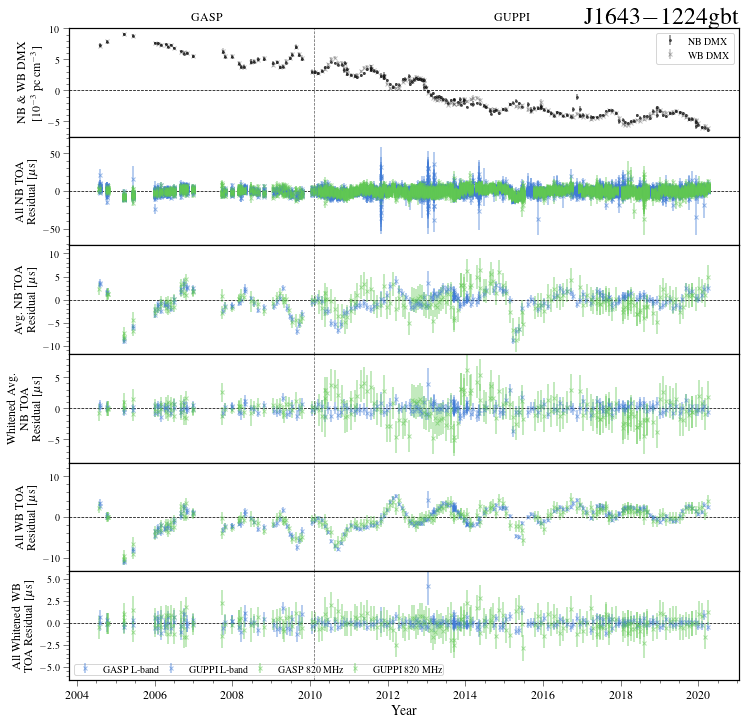

In [2]:
for p in psr_names:
    name = p.split('/')[1]
    log.info(f'Working on {name}')
    #if os.path.isfile(f'{name}.png'):
        #log.info(f'{name}.png already exists, skipping')
        #continue
    fo_nb, mo_nb = plt_util.get_fitter(f'{p}.nb.yaml')
    fo_wb, mo_wb = plt_util.get_fitter(f'{p}.wb.yaml')
    if not testing:
        try:
            fo_nb.fit_toas()
            fo_wb.fit_toas()
        except:
            log.warning(f'Issue with {name}; skipping')
            continue
    # Non-averaged, non-whitened NB:
    res_nb = fo_nb.resids.time_resids.to(u.us)
    res_nb_errs = fo_nb.resids.get_data_error().to(u.us)
    
    # Non-averaged, non-whitened WB:
    res_wb = fo_wb.resids.residual_objs['toa'].time_resids.to(u.us)
    res_wb_errs = fo_wb.resids.residual_objs['toa'].get_data_error().to(u.us)
    
    # Averaged, non-whitened (NB only):
    avg_dict = fo_nb.resids.ecorr_average(use_noise_model=True)
    res_avg_nb = avg_dict['time_resids'].to(u.us)
    res_avg_nb_errs = avg_dict['errors'].to(u.us)
    
    # Averaged, whitened (NB only):
    res_avg_white_nb = tu.whiten_resids(avg_dict).to(u.us)
    res_avg_white_nb_errs = res_avg_nb_errs
    
    # Non-averaged, whitened WB:
    if not testing:
        res_white_wb = tu.whiten_resids(fo_wb).to(u.us)
        res_white_wb_errs = res_wb_errs

    years_nb, years_wb, years_avg = plt_util.get_avg_years(fo_nb, fo_wb, avg_dict)

    DMXs_nb, DMX_vErrs_nb, DMX_center_Year_nb = plt_util.get_DMX_info(fo_nb)
    DMXs_wb, DMX_vErrs_wb, DMX_center_Year_wb = plt_util.get_DMX_info(fo_wb)

    rcvr_bcknds_nb, rcvr_bcknds_wb, rcvr_bcknds_avg = plt_util.get_backends(fo_nb, fo_wb, avg_dict)

    rn_nb, rn_wb = plt_util.rn_sub(testing, rn_subtract, fo_nb, fo_wb)

    has_rn = False
    if 'PLRedNoise' in mo_nb.components.keys():
        has_rn = True        
    if has_rn == True:
        fig, axs = plt.subplots(6, 1, sharex=True, figsize=(12, 12))
    else:
        fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
    plt.subplots_adjust(hspace=0)
    
    title = mo_nb.PSR.value
    if '-' in title:
        title = title.split('-')[0] + '$-$' + title.split('-')[1]
    
    # Change for title location
    #fig.suptitle(f'{title}', fontsize=16, y=0.93)
    
    plt.xlabel('Year', fontsize=14)
    for a in axs:
        a.axhline(y=0,linewidth=0.75,color='k',linestyle='--')
        a.minorticks_on()
        
    # NB AND WB DMX
    axs[0].set_ylabel('NB \& WB DMX\n[10$^{-3}$ pc cm$^{-3}$]' )
    axs[0].errorbar(DMX_center_Year_nb, DMXs_nb*10**3, yerr=DMX_vErrs_nb*10**3, fmt='.', c='k', alpha=0.5, label='NB DMX')
    axs[0].errorbar(DMX_center_Year_wb, DMXs_wb*10**3, yerr=DMX_vErrs_wb*10**3, fmt='x', c='k', alpha=0.25, label='WB DMX')
    axs[0].legend(loc='best')    
    axs[0].text(axs[0].get_xlim()[1], 1.1, title, transform=axs[0].get_xaxis_transform(), va='center', ha='right', fontsize=24)

    
    # NON-AVERAGED NB TOAs UN-WHITENED
    axs[1].set_ylabel('All NB TOA\nResidual [$\mu$s]')
    plt_util.plot_by_color(axs[1], years_nb, res_nb, res_nb_errs, rcvr_bcknds_nb, 0.0, be_legend=False, be_format=be_format)
    
    # AVERAGED NB TOAs UN-WHITENED
    axs[2].set_ylabel('Avg.~NB TOA\nResidual [$\mu$s]')
    plt_util.plot_by_color(axs[2], years_avg, res_avg_nb, res_avg_nb_errs, rcvr_bcknds_avg, 0.0, be_legend=False, be_format=be_format)
    
    if has_rn:
        # AVERAGED NB TOAs WHITENED
        axs[3].set_ylabel('Whitened Avg.\nNB TOA\nResidual [$\mu$s]')
        if not testing:
            plt_util.plot_by_color(axs[3], years_avg, res_avg_white_nb, res_avg_nb_errs, rcvr_bcknds_avg, rn_nb, be_legend=False, be_format=be_format)
        # WB TOAs UN-WHITENED
        axs[4].set_ylabel('All WB TOA\nResidual [$\mu$s]')
        plt_util.plot_by_color(axs[4], years_wb, res_wb, res_wb_errs, rcvr_bcknds_wb, 0.0, be_legend=False, be_format=be_format)
        # WB TOAs WHITENED
        axs[5].set_ylabel('All Whitened WB\nTOA Residual [$\mu$s]')
        if not testing:
            plt_util.plot_by_color(axs[5], years_wb, res_white_wb, res_white_wb_errs, rcvr_bcknds_wb, rn_wb, be_legend=be_legend, be_format=be_format)
    else:
        # WB TOAs UN-WHITENED
        axs[3].set_ylabel('All WB TOA\nResidual [$\mu$s]')
        plt_util.plot_by_color(axs[3], years_wb, res_wb, res_wb_errs, rcvr_bcknds_wb, 0.0, be_legend=be_legend, be_format=be_format)
        
    plt_util.rec_labels(axs, rcvr_bcknds_nb, years_avg)
    plt.savefig(f'{mo_nb.PSR.value}.png', dpi=100, transparent=False, bbox_inches='tight')
    plt.show()